# Проведение АВ теста.

## Постановка задачи
<li>Провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
<li>Оцените корректность проведения теста
<li>Проанализируйте результаты теста
<li>Чтобы оценить корректность проведения теста, проверьте:
<li>пересечение тестовой аудитории с конкурирующим тестом,
<li>совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

## Техническое задание

<li>Название теста: recommender_system_test;
<li>Группы: А (контрольная), B (новая платёжная воронка);
<li>Дата запуска: 2020-12-07;
<li>Дата остановки набора новых пользователей: 2020-12-21;
<li>Дата остановки: 2021-01-04;
<li>Аудитория: 15% новых пользователей из региона EU;
<li>Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
<li>Ожидаемое количество участников теста: 6000.
<li>Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
<li>конверсии в просмотр карточек товаров — событие product_page
<li>просмотры корзины — product_cart
<li>покупки — purchase.

## План работы.

<li>Исследуйте данные:
<li>Требуется ли преобразование типов?
<li>Есть ли пропущенные значения и дубликаты? Если да, то какова их природа?
<li>Проведите исследовательский анализ данных:
<li>Исследуйте конверсию в воронке на разных этапах;
<li>Обладают ли выборки одинаковыми распределениями количества событий на пользователя?
<li>Присутствуют ли в выборках одни и те же пользователи?
<li>Как число событий распределено по дням?
<li>Есть ли в данных ещё какие-то особенности, которые нужно учесть, прежде чем приступать к A/B-тестированию?
<li>Проведите оценку результатов A/B-тестирования:
<li>Проверьте статистическую разницу долей z-критерием;
<li>Что можно сказать про результаты A/B-тестирования?
<li>Опишите выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования.

In [134]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go 
import seaborn as sns
import math as mth
from scipy import stats as st
import datetime
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

### Последовательно загружу каждый датасет и исследую его.

<b>Календарь маркетинговых событий на 2020 год.</b>

In [135]:
ab_project_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

In [136]:
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Описание данных:
<li>name — название маркетингового события;
<li>regions — регионы, в которых будет проводиться рекламная кампания;
<li>start_dt — дата начала кампании;
<li>finish_dt — дата завершения кампании.

In [137]:
ab_project_marketing_events.duplicated().sum()

0

In [138]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


<b>Пропущенных значений и дубликатов нет. </b>Приведу столбцы с датами к типу datetime.

In [139]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

Посмотрю распределение значений дат.

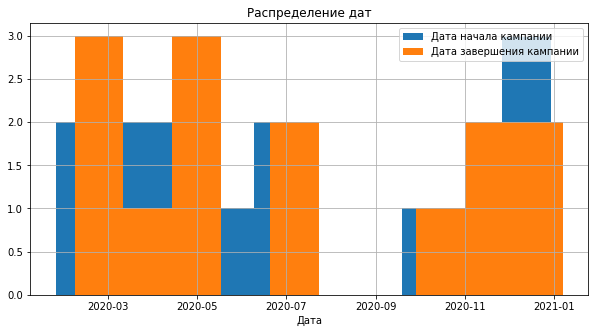

In [140]:
plt.title('Распределение дат')
ab_project_marketing_events['start_dt'].hist(figsize=(10,5))
ab_project_marketing_events['finish_dt'].hist(figsize=(10,5))
plt.legend(['Дата начала кампании', 'Дата завершения кампании'])
plt.xlabel('Дата')
plt.show()

Посмотрю на события.

In [141]:
ab_project_marketing_events.name.value_counts()

Black Friday Ads Campaign           1
4th of July Promo                   1
Easter Promo                        1
St. Patric's Day Promo              1
Single's Day Gift Promo             1
St. Valentine's Day Giveaway        1
International Women's Day Promo     1
Chinese Moon Festival               1
Dragon Boat Festival Giveaway       1
Chinese New Year Promo              1
CIS New Year Gift Lottery           1
Christmas&New Year Promo            1
Victory Day CIS (May 9th) Event     1
Labor day (May 1st) Ads Campaign    1
Name: name, dtype: int64

Посмотрю на регионы.

In [142]:
ab_project_marketing_events.regions.value_counts()

APAC                        4
EU, CIS, APAC, N.America    3
EU, CIS, APAC               2
CIS                         2
EU, N.America               2
N.America                   1
Name: regions, dtype: int64

Аномалий нет.

<b>Все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года.</b>

In [143]:
final_ab_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')

In [144]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Описание данных:
<li>user_id — идентификатор пользователя;
<li>first_date — дата регистрации;
<li>region — регион пользователя;
<li>device — устройство, с которого происходила регистрация.

In [145]:
final_ab_new_users.duplicated().sum()

0

In [146]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


<b>Пропущенных значений и дубликатов нет. </b> Приведу столбец с датой к типу datetime.

In [147]:
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

Посмотрю распределение значений дат.

In [148]:
final_ab_new_users['first_date'].value_counts()

2020-12-21    6290
2020-12-14    5654
2020-12-07    5595
2020-12-13    4691
2020-12-20    4288
2020-12-12    3963
2020-12-19    3617
2020-12-18    3365
2020-12-08    3239
2020-12-22    3083
2020-12-10    3076
2020-12-17    3048
2020-12-15    3043
2020-12-11    2390
2020-12-23    2180
2020-12-16    2110
2020-12-09    2101
Name: first_date, dtype: int64

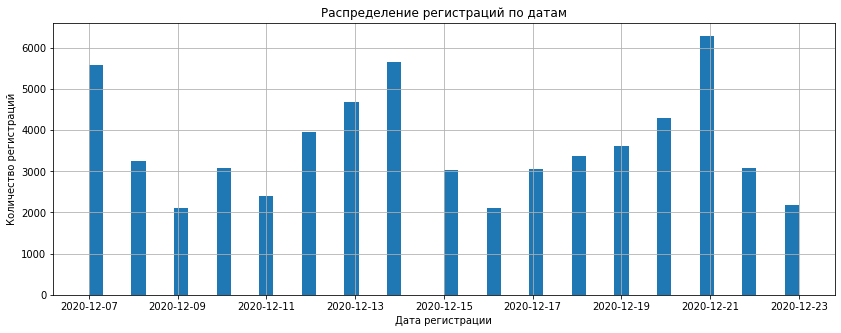

In [149]:
plt.title('Распределение регистраций по датам')
final_ab_new_users['first_date'].hist(figsize=(14,5), bins = 50)
plt.xlabel('Дата регистрации')
plt.ylabel('Количество регистраций')
plt.show()

Аномалий нет. Наблюдается цикличность. К началу неделю регистраций становится меньше и затем, к концу недели количество увеличивается.

Посмотрю на регионы.

In [150]:
final_ab_new_users.groupby('region', as_index = False).agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)

,region,user_id
2,EU,46270
3,N.America,9155
1,CIS,3155
0,APAC,3153


<b>Больше всего пользователей из Европы.</b>

Посмотрю на устройства.

In [151]:
final_ab_new_users.device.value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

<b>Устройства на Android самые популярные у пользователей.</b>

<b>Все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.</b>

In [152]:
final_ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')

In [153]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Описание данных:
<li>user_id — идентификатор пользователя;
<li>event_dt — дата и время события;
<li>event_name — тип события;
<li>details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

In [154]:
final_ab_events.duplicated().sum()

0

In [155]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


<b>Есть пропущенные значения в столбце details. Это вполне закономерно, так как сведения о сумме покупки поступают на одном определенном шагею Заменю пропуски на 0. Дубликатов нет. </b> Приведу столбец с датой к типу datetime.

In [156]:
final_ab_events['details'] = final_ab_events['details'].fillna(0)

In [157]:
final_ab_events.isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

In [158]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

Посмотрю распределение значений дат.

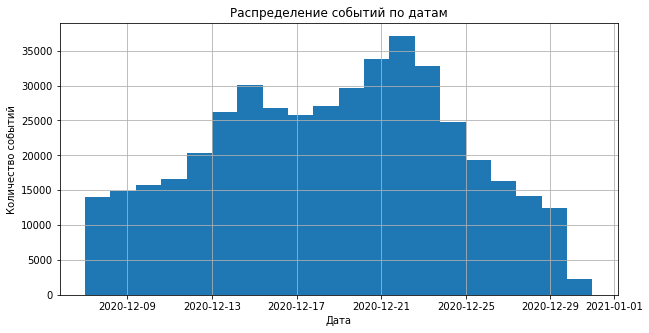

In [159]:
plt.title('Распределение событий по датам')
final_ab_events['event_dt'].hist(figsize=(10,5), bins=20)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

Аномалий нет.

Рассмотрю типы события.

In [160]:
final_ab_events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

<li>конверсии в просмотр карточек товаров — событие product_page
<li>просмотры корзины — product_cart
<li>покупки — purchase.

<b>Таблица участников тестов.</b>

In [161]:
final_ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [162]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Описание данных:
<li>user_id — идентификатор пользователя;
<li>ab_test — название теста;
<li>group — группа пользователя.

In [163]:
final_ab_participants.duplicated().sum()

0

In [164]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


In [165]:
final_ab_participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

<b>Пропущенных значений и дубликатов нет. </b> Типы приведены верно.

### <b>Посмотрю пересечение тестовой аудитории с конкурирующим тестом.</b>

In [166]:
df_interface_eu_test = final_ab_participants.query('ab_test == "interface_eu_test"')
df_recommender_system_test = final_ab_participants.query('ab_test == "recommender_system_test"')

In [167]:
df_interface_eu_test.shape, df_recommender_system_test.shape

((11567, 3), (6701, 3))

In [168]:
df1 = df_interface_eu_test.merge(df_recommender_system_test, on = 'user_id', how='inner')

In [169]:
df1.shape

(1602, 5)

<b>1602 пользователя участвуют в конкурирующих тестах одновременно.</b>

### <b>Проверю корректность предоставленных данных с техническим заданием.</b>

Название теста: recommender_system_test.

In [170]:
final_ab_participants.ab_test.value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

У нас в данных присутствуют 2 теста. Сделаю срез данных для требуемого теста.

In [171]:
final_ab_participants = final_ab_participants.query('ab_test == "recommender_system_test"')

Группы: А (контрольная), B (новая платёжная воронка).

In [172]:
final_ab_participants.group.value_counts()

A    3824
B    2877
Name: group, dtype: int64

Тут все верно. Других групп нет.

Дата запуска: 2020-12-07.

In [173]:
final_ab_events.event_dt.min()

Timestamp('2020-12-07 00:00:33')

Тут все верно.

Дата остановки набора новых пользователей: 2020-12-21.

In [174]:
final_ab_new_users.first_date.max()

Timestamp('2020-12-23 00:00:00')

В данных указана дата остановки набора 23 декабря 2021 года. Сделаю срез данных для нужной даты.

In [175]:
final_ab_new_users = final_ab_new_users.query('first_date <= "2020-12-21 00:00:00"')

Дата остановки: 2021-01-04.

In [176]:
final_ab_events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

В предоставленных данных указана последняя дата - 30 декабря 2020 года.

Аудитория: 15% новых пользователей из региона EU.

In [177]:
df_region = pd.merge(final_ab_participants, final_ab_new_users, on = 'user_id', how = 'inner')

In [178]:
df_region.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [179]:
df_region.query('region == "EU"').user_id

0       D1ABA3E2887B6A73
1       A7A3664BD6242119
2       DABC14FDDFADD29E
3       04988C5DF189632E
4       482F14783456D21B
              ...       
6346    7C5C12FA1B5AB710
6347    91C3969B8A72B908
6348    E26F13A65CEAC6EA
6349    95401934D6D6D4FC
6350    80712ED4EA1B52A5
Name: user_id, Length: 6351, dtype: object

In [180]:
final_ab_new_users.query('region == "EU" and first_date <= "2020-12-21"').user_id.nunique() 

42340

In [181]:
df_region.query('region == "EU"').user_id.nunique() / final_ab_new_users.query('region == "EU" and first_date <= "2020-12-21"').user_id.nunique()   

0.15

Видно, что из региона EU 15% пользователей, из числа европейских пользователей, попавших в тест.

Ожидаемое количество участников теста: 6000.

In [182]:
final_ab_participants.group.value_counts().sum()

6701

В исходных данных количество участнков подходит под техзадание.

<b>Выводы:</b>

- В тесте участвуют 6701 пользователей. 94% пользователей из Европы. 1602 (24%) пользователя участвуют в обох тестах одновременно.
    
    В предоставленных данных были обнаружены несоответствия:
- В таблице с данными теста был указан еще один тест, не указанный в техзадании;
- Дата остановки набора новых пользователей дольше на 2 дня;
- Дата остановки теста на 5 дней раньше указанной в тех задании.
-
Все несоответствия были удалены из исходных данных.

### Проверю совпадение теста и маркетинговых событий. 
Так как я знаю, что события пользователей происходили c 7 по 30 декабря 2020 года, я легко найду в календаре акцию, подходящую к этой дате. 

In [183]:
def events(start_date, end_date, region):
    '''Функция выводит события, произошедшие в выбранном регионе на выбранные даты.
    '''
    return ab_project_marketing_events.query('(regions.str.contains(@region).values) & \
    (start_dt >= @start_date & start_dt <= @end_date) or \
    (finish_dt >= @start_date & finish_dt <= @end_date) or \
    (start_dt <= @start_date & finish_dt >= @end_date)') 

In [184]:
events('2020-12-07', '2020-12-30', 'EU, N.America')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Подходит 1 акция - Christmas&New Year Promo.

### Исследую конверсию в воронке для разных тестируемых групп на разных этапах. 
Для этого объединю датасеты с данными тестированя и данными событий.

In [185]:
df_for_funnel = pd.merge(final_ab_events, final_ab_participants, on = 'user_id', how = 'inner')

In [186]:
df_for_funnel.head()

,user_id,event_dt,event_name,details,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,0.00,A,recommender_system_test
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,0.00,A,recommender_system_test
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,0.00,A,recommender_system_test


#### Узнаю сколько пользователей не совершили ни одного действия.

In [187]:
df_for_funnel.user_id.nunique()

3675

In [188]:
final_ab_participants.user_id.nunique()

6701

In [189]:
print('Количество пользователей, не совершивших ни одного действия: {}'.format(final_ab_participants.user_id.nunique() - df_for_funnel.user_id.nunique()))

Количество пользователей, не совершивших ни одного действия: 3026


Почти половина пользователей (3026 чел.) не совершили ни одного действия. Возможно, люди нашли искомое на других ресурсах. Или система не учла их активность.

In [190]:
df_A = df_for_funnel.query('group == "A"').groupby('event_name', as_index = False).agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
df_B = df_for_funnel.query('group == "B"').groupby('event_name', as_index = False).agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
df_A.columns = ['event_name', 'user_counts']
df_B.columns = ['event_name', 'user_counts']

In [191]:
df_A

,event_name,user_counts
0,login,2747
2,product_page,1780
3,purchase,872
1,product_cart,824


In [192]:
df_B

,event_name,user_counts
0,login,928
2,product_page,523
3,purchase,256
1,product_cart,255


Логично предположить путь, который проделывает покупатель: login - product_page - product_cart - purchase. Но мы наблюдаем несоответствие на последнем шаге. Идет сначала покупка, а потом просмотр корзины. Возможно, есть вариант оплаты заказа без посещения корзины. Исправлю в таблицах последовательность шагов согласно этой логике.

In [193]:
df_A['order_good'] = [0,1,3,2]
df_A = df_A.sort_values(by='order_good')
df_B['order_good'] = [0,1,3,2]
df_B = df_B.sort_values(by='order_good')

In [194]:
df_A

,event_name,user_counts,order_good
0,login,2747,0
2,product_page,1780,1
1,product_cart,824,2
3,purchase,872,3


In [195]:
df_B

,event_name,user_counts,order_good
0,login,928,0
2,product_page,523,1
1,product_cart,255,2
3,purchase,256,3


Добавлю в эти таблицы колонку с конверсиями.

In [196]:
val = df_A.user_counts.values
def conversion(row):
    '''Функция рассчитывает конверсию на каждом шаге.
    '''
    if row == "login": return (val[0]/val[0]) * 100
    elif row == "product_page": return (val[1]/val[0]) * 100
    elif row == "product_cart": return (val[2]/val[0]) * 100
    elif row == "purchase": return (val[3]/val[0]) * 100

In [197]:
df_A['conversion'] = df_A['event_name'].apply(conversion)
df_A

,event_name,user_counts,order_good,conversion
0,login,2747,0,100.000000
2,product_page,1780,1,64.797961
1,product_cart,824,2,29.996360
3,purchase,872,3,31.743720


In [198]:
val = df_B.user_counts.values
df_B['conversion'] = df_B['event_name'].apply(conversion)

In [199]:
df_B

,event_name,user_counts,order_good,conversion
0,login,928,0,100.000000
2,product_page,523,1,56.357759
1,product_cart,255,2,27.478448
3,purchase,256,3,27.586207


Итоговая конверсия выше у группы А. Это означает, что изменения не повлияли на покупателей. Да и в целом, рассматривая конверсию каждого шага, группа А показывает лучшие результаты.

### Построю сводную воронку для конверсий.

In [200]:
text = 'Количество пользователей на каждом шаге в AB группах'
stages=['Login', 'Product_page', 'Product_cart', 'Purchase']
fig1 = go.Figure(go.Funnel(y = stages, x = df_A['user_counts'], name='A', textinfo = "value+percent initial+percent previous"))
fig2 = go.Figure(go.Funnel(y = stages, x = df_B['user_counts'], name='B', textinfo = "value+percent initial+percent previous"))


fig = go.Figure(data = fig1.data + fig2.data, layout_title_text = text)
fig.show()

<b>Выводы:</b>На графике воронки видно уменьшение конверсии с каждым шагом. При переходе от product_cart до purchase конверсия наоборот увеличилась, но связано это, скорее всего с тем, что пользователи минуют корзину и переходят сразу к оплате. Возможно, при переходе к покупке система ошибочно сама направляет клиента минуя корзину.

Узнаю, обладают ли выборки одинаковыми распределениями количества событий на пользователя.

In [201]:
df1 = df_for_funnel.query('group == "A"').groupby('user_id', as_index = False).agg({'event_name':'nunique'})
df2 = df_for_funnel.query('group == "B"').groupby('user_id', as_index = False).agg({'event_name':'nunique'})

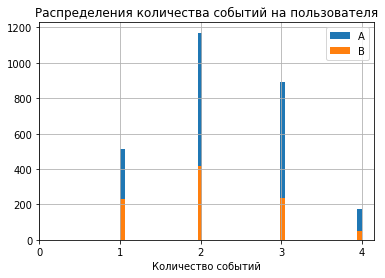

In [202]:
df1['event_name'].hist(figsize = (6, 4), label = 'A', bins = 50)
df2['event_name'].hist(figsize = (6, 4), label = 'B', bins = 50)
plt.legend(['A', 'B'])
plt.title('Распределения количества событий на пользователя')
plt.xlabel('Количество событий')
plt.xticks([0,1,2,3,4])
plt.show()

In [203]:
df_for_funnel.query('group == "A"').groupby('user_id', as_index = False).agg({'event_name':'nunique'}).describe()

,event_name
count,2747.000000
mean,2.265380
std,0.834336
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


In [204]:
df_for_funnel.query('group == "B"').groupby('user_id', as_index = False).agg({'event_name':'nunique'}).describe()

,event_name
count,928.000000
mean,2.114224
std,0.836010
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


- В группе А и В на 75% пользователей приходится 3 события, в среднем, по 2 события на человека.
- Можно однозначно сказать, что у разных групп одинаковое количество событий на одного человека.

Теперь рассмотрю распределение всех событий (в том числе и повторяющихся) на одного клиента в каждой группе.

In [205]:
df01 = df_for_funnel.query('group == "A"').groupby('user_id', as_index = False).agg({'event_name':'count'})
df02 = df_for_funnel.query('group == "B"').groupby('user_id', as_index = False).agg({'event_name':'count'})

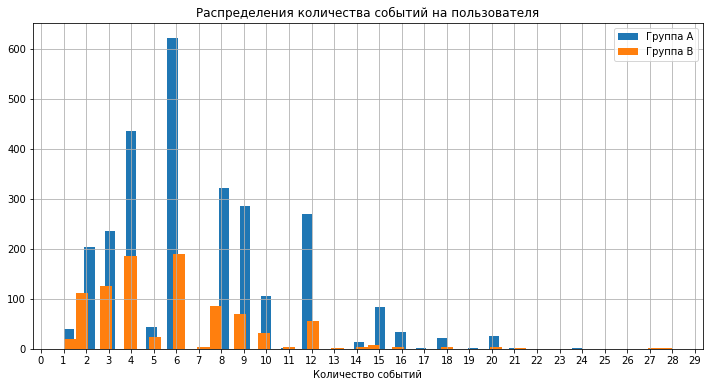

In [206]:
df01['event_name'].hist(figsize = (12, 6), label = 'A', bins = 50)
df02['event_name'].hist(figsize = (12, 6), label = 'B', bins = 50)
plt.legend(['Группа A', 'Группа B'])
plt.title('Распределения количества событий на пользователя')
plt.xlabel('Количество событий')
plt.xticks(range(30))
plt.show()

In [207]:
df_for_funnel.query('group == "A"').groupby('user_id', as_index = False).agg({'event_name':'count'}).describe()

,event_name
count,2747.000000
mean,7.027303
std,3.868983
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


In [208]:
df_for_funnel.query('group == "B"').groupby('user_id', as_index = False).agg({'event_name':'count'}).describe()

,event_name
count,928.000000
mean,5.812500
std,3.483878
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,28.000000


В целом, характер распределения остался похожим, изменилось только количество событий. Причем в группе с меньшим количеством людей (В) больше разброс в количестве событий. В группе А, в среднем приходится 7 событий на человека, в В - 5-6.

### Узнаю, присутствуют ли в выборках одни и те же пользователи. 
Для этого объединю таблицы для каждой группы по пересечению номера клиента и посчитаю их количество.

In [209]:
dfA = df_for_funnel.query('group == "A"')
dfB = df_for_funnel.query('group == "B"')

In [210]:
df12 = pd.merge(dfA, dfB, on = 'user_id', how = 'inner')

In [211]:
df12

,user_id,event_dt_x,event_name_x,details_x,group_x,ab_test_x,event_dt_y,event_name_y,details_y,group_y,ab_test_y


Таблица получилась пустая, что говорит о том, что в таблицах с разными группами не было одинаковых пользователей (user_id).

### Узнаю как число событий распределено по дням. 
Для этого столбец с датой округлю до дней.

In [212]:
df_event = df_for_funnel.groupby(['event_dt', 'group'], as_index = False).agg({'event_name':'count'})
df_event['event_dt'] = df_event['event_dt'].astype('datetime64[D]')
df_event.head()

,event_dt,group,event_name
0,2020-12-07,B,2
1,2020-12-07,B,2
2,2020-12-07,B,1
3,2020-12-07,B,1
4,2020-12-07,A,2


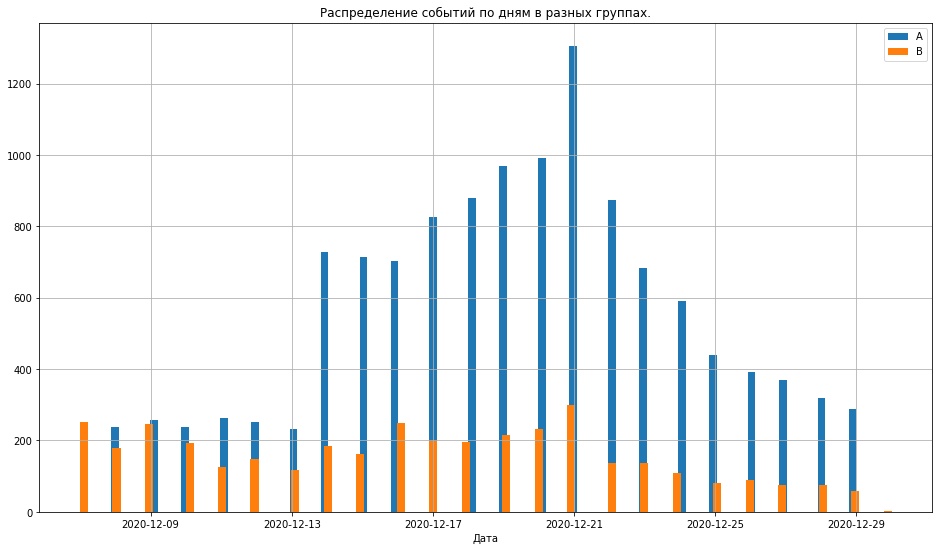

In [213]:
plt.title('Распределение событий по дням в разных группах.')
df_event.query('group == "A"')['event_dt'].hist(figsize = (16,9), bins = 100, label = "A")
df_event.query('group == "B"')['event_dt'].hist(figsize = (16,9), bins = 100, label = "B")
plt.legend()
plt.xlabel('Дата')
plt.show()

В обеих группах наблюдается увеличение количества событий к концу второй декады декабря. И затем, спад. Это говорит о том, что промоакции в эти дни не приносят увеличения покупок. Также виден скачок в группе А 21 декабря, а в группе В его нет. Это может считаться выбросом, не подходящим для корректного проведения теста.

### Проведите оценку результатов A/B-тестирования. Проверьте статистическую разницу долей z-критерием.


Для проверки статистической значимости различия в конверсии Login → Product_cart АB групп применю z-тест. Для этого сделаю функцию z_test.

Для проведения анализа статистической значимости различия в конверсиях АB групп сформулирую нулевую и альтернативную гипотезу:

<li>Нулевая гипотеза: Статистически значимых различий в конверсиях АB групп нет.
<li>Альтернативная гипотеза: Статистически значимые различия в конверсиях АB групп есть.

In [214]:
alpha = .05 # критический уровень статистической значимости

In [215]:
def z_test (successes, trials):
    p1 = successes[0]/trials[0] # пропорция успехов в первой группе
    p2 = successes[1]/trials[1] # пропорция успехов во второй группе
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) # пропорция успехов в комбинированном датасете
    difference = p1 - p2 # разница пропорций в датасетах
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value.round(2))
    print('Доля А: {}, Доля B: {}'.format(p1.round(2), p2.round(2)))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [216]:
df_AB = pd.merge(df_A, df_B, on = 'event_name', suffixes = ['_A', '_B'])
df_AB = df_AB.drop(['order_good_A', 'order_good_B'], axis = 1)
df_AB

,event_name,user_counts_A,conversion_A,user_counts_B,conversion_B
0,login,2747,100.000000,928,100.000000
1,product_page,1780,64.797961,523,56.357759
2,product_cart,824,29.996360,255,27.478448
3,purchase,872,31.743720,256,27.586207


In [217]:
successes = np.array([df_AB.iloc[3,1], df_AB.iloc[3,3]])
trials = np.array([df_AB.iloc[0,1], df_AB.iloc[0,3]])
z_test(successes, trials)

p-значение:  0.02
Доля А: 0.32, Доля B: 0.28
Отвергаем нулевую гипотезу: между долями есть значимая разница


Для проверки статистической значимости различия в конверсиях каждого шага АB групп применю z-тест. Но сначала, применю поправку Бонферрони к уровням значимости. Так как рассматриваю 4 нулевых гипотезы, то Бонферонни = alpha/4.

In [218]:
df_AB

,event_name,user_counts_A,conversion_A,user_counts_B,conversion_B
0,login,2747,100.000000,928,100.000000
1,product_page,1780,64.797961,523,56.357759
2,product_cart,824,29.996360,255,27.478448
3,purchase,872,31.743720,256,27.586207


In [219]:
alpha = alpha / 4

successes = np.array([df_AB.iloc[1,1], df_AB.iloc[1,3]])
trials = np.array([df_AB.iloc[0,1], df_AB.iloc[0,3]])
print('Шаг Login → Product_page')
print()
z_test(successes, trials)

successes = np.array([df_AB.iloc[2,1], df_AB.iloc[2,3]])
trials = np.array([df_AB.iloc[0,1], df_AB.iloc[0,3]])
print()
print('Шаг Product_page → Purchase')
print()
z_test(successes, trials)

successes = np.array([df_AB.iloc[3,1], df_AB.iloc[3,3]])
trials = np.array([df_AB.iloc[0,1], df_AB.iloc[0,3]])
print()
print('Шаг Purchase → Product_cart')
print()
z_test(successes, trials)

Шаг Login → Product_page

p-значение:  0.0
Доля А: 0.65, Доля B: 0.56
Отвергаем нулевую гипотезу: между долями есть значимая разница

Шаг Product_page → Purchase

p-значение:  0.15
Доля А: 0.3, Доля B: 0.27
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Purchase → Product_cart

p-значение:  0.02
Доля А: 0.32, Доля B: 0.28
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании проведенных z-тестов можно говорить о следующем:
- В общей конверсии нет статистически значимой разницы в разных группах, т.е. внесенные изменения никак не повлияли на покупателей;
- Рассматривая различия в конверсиях каждого шага только на шаге Login → Product_page наблюдается статистически значимая разница, т.е. внесенные изменения сильно повлияли на покупателей.

### Проверю предположение, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%.

Для этого, путем объединения, составлю таблицу с активностью пользователей, входящих в тест и датой их регистрации. Сравню дату события с датой двухнедельного срока после регистрации и сделаю срез по таким событиям.

In [220]:
final = pd.merge(final_ab_participants, final_ab_new_users, on = 'user_id', how = 'inner')
final = pd.merge(final, final_ab_events, on = 'user_id', how = 'inner')
final.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,0.00
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,0.00


In [221]:
final['event_dt'] = final['event_dt'].astype('datetime64[D]')

In [222]:
final['last_date'] = final['first_date'].apply(lambda row: row + datetime.timedelta(days=14))

In [223]:
final.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,last_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,purchase,99.99,2020-12-21
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25,purchase,4.99,2020-12-21
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_cart,0.00,2020-12-21
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25,product_cart,0.00,2020-12-21
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_page,0.00,2020-12-21


In [224]:
def event_date_2_week(row):
    """Функция определяет входит ли дата события в двухнедельный срок после регистрации.
    """
    if row[6] <= row[9]: 
        return "True"
    else: 
        return "False"

In [225]:
final['event_dt_2week'] = final.apply(event_date_2_week, axis=1)

In [226]:
final.event_dt_2week.value_counts()

True     24070
False      628
Name: event_dt_2week, dtype: int64

628 наблюдений придется исключить, как не удовлетворяющие условию. 

In [227]:
final = final.query('event_dt_2week == "True"')

In [228]:
df_A_final = final.query('group == "A"').groupby('event_name', as_index = False).agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
df_B_final = final.query('group == "B"').groupby('event_name', as_index = False).agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
df_A_final.columns = ['event_name', 'user_counts']
df_B_final.columns = ['event_name', 'user_counts']

In [229]:
val = df_A_final.user_counts.values
def conversion(row):
    '''Функция рассчитывает конверсию на каждом шаге.
    '''
    if row == "login": return (val[0]/val[0]) * 100
    elif row == "product_page": return (val[1]/val[0]) * 100
    elif row == "product_cart": return (val[2]/val[1]) * 100
    elif row == "purchase": return (val[3]/val[2]) * 100

In [230]:
df_A_final['conversion'] = df_A_final['event_name'].apply(conversion)

In [231]:
val = df_B.user_counts.values
df_B_final['conversion'] = df_B_final['event_name'].apply(conversion)

Рассчитаю конверсию по новым данным.

In [232]:
df_A_final['order_good'] = [0,1,3,2]
df_A_final = df_A_final.sort_values(by='order_good')
df_B_final['order_good'] = [0,1,3,2]
df_B_final = df_B_final.sort_values(by='order_good')

In [233]:
df_A_final

,event_name,user_counts,conversion,order_good
0,login,2747,100.000000,0
2,product_page,1780,64.797961,1
1,product_cart,824,48.988764,2
3,purchase,872,94.495413,3


In [234]:
df_B_final

,event_name,user_counts,conversion,order_good
0,login,927,100.000000,0
2,product_page,523,56.357759,1
1,product_cart,255,48.757170,2
3,purchase,256,100.392157,3


При сравнении конверсии в разных группах за двухнедельный период с момента регистрации по каждому шагу нет увеличения на 10%.

In [235]:
text = 'Количество пользователей на каждом шаге в AB группах'
stages=['Login', 'Product_page', 'Product_cart', 'Purchase']
fig1 = go.Figure(go.Funnel(y = stages, x = df_A['user_counts'], name='A'))
fig2 = go.Figure(go.Funnel(y = stages, x = df_B['user_counts'], name='B'))
fig = go.Figure(data = fig1.data + fig2.data, layout_title_text = text)
fig.show()

Выводы:На графике воронки видно уменьшение конверсии с каждым шагом. При переходе от product_cart до purchase конверсия наоборот увеличилась, но связано это, скорее всего с тем, что пользователи минуют корзину и переходят сразу к оплате. Возможно, при переходе к покупке система ошибочно сама направляет клиента минуя корзину. Воронка такая же, как и до среза.

## Общие выводы:

<b>Исходные данные.</b>

<li>В предоставленных данных были обнаружены несоответствия:
<li>В таблице с данными теста был указан еще один тест, не указанный в техзадании;
<li>Дата остановки набора новых пользователей дольше на 2 дня;
<li>Дата остановки теста на 5 дней раньше указанной в тех задании.

<b>Исследование клиентов.</b>
    
<li>94% пользователей из региона EU.
<li>В тесте участвуют 6701 пользователей. 
<li>1602 (24%) пользователя участвуют в обох тестах одновременно.
<li>В даты теста проходит 1 акция - "Christmas&New Year Promo".
<li>Почти половина пользователей (3026 чел.) не совершили ни одного действия. Возможно, люди нашли искомое на других ресурсах. Или система не учла их активность.
<li>Предполагаемая последовательность действий покупателя: login - product_page - product_cart - purchase. Но мы наблюдаем несоответствие на последнем шаге. Идет сначала покупка, а потом просмотр корзины. Возможно, есть вариант оплаты заказа без посещения корзины.
<li>Распределения количества всех событий на одного человека: в группе А, в среднем приходится 7 событий на человека, в В - 5-6.
<li>В таблицах с разными группами не было одинаковых пользователей (user_id)
<li>В обеих группах наблюдается увеличение количества событий к концу второй декады декабря. И затем, спад. Это говорит о том, что промоакции в эти дни не приносят увеличения покупок.
    
<b>Исследование гипотез.</b>
    
<li>В обоих группах наибольшее уменьшение конверсии происходит при переходе от login к product_page, причем в группе В больше на 8%, чем в А. До шага product_cart в обоих группах конверсия - 46-48%. То есть, до шага покупки доходит около 13-14% покупателей от начального количества. Похоже, что исследуемые изменения уменьшили конверсию до шага product_page, но в целом не уменьшили итоговую конверсию
<li>На графике воронки видно уменьшение конверсии с каждым шагом. При переходе от product_cart до purchase конверсия наоборот увеличилась, но связано это, скорее всего с тем, что пользователи минуют корзину и переходят сразу к оплате. Возможно, при переходе к покупке система ошибочно сама направляет клиента минуя корзину.
<li>В общей конверсии нет статистически значимой разницы в разных группах, т.е. внесенные изменения никак не повлияли на покупателей;
<li>Рассматривая различия в конверсиях каждого шага только на шаге Login → Product_page наблюдается статистически значимая разница, т.е. внесенные изменения сильно повлияли на покупателей.
<li>Проверив предположение, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10% я его отвергаю.
При сравнении конверсии в разных группах за двухнедельный период с момента регистрации по каждому шагу нет увеличения на 10%.

## Заключение:

Проведенный АВ тест нельзя считать корректным. Не было проведено АА теста. Тест проводился во время новогодних распродаж, что внесло свои искажения в активность клиентов. В даты исследования попала только одна промоакция.